## От VAE к DDPM

План на сегодня: реализуем генерацию лиц с обучением
- Variational autoencoder (VAE)
- Denoising diffusion probalilistic model (DDPM)

### Подготовим данные

Всё с прошлой недели:

In [1]:
from pathlib import Path
from typing import Callable, cast

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
class ImageDataset(Dataset):
    def __init__(
        self,
        datadir: Path,
        transform: Callable[[Image.Image], Tensor],
        pattern: str = "*.jpg",
    ) -> None:
        self.images = list(datadir.rglob(pattern))
        self.transform = transform

    def __getitem__(self, index) -> Tensor:
        img = Image.open(self.images[index])
        return self.transform(img)

    def __len__(self) -> int:
        return len(self.images)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [4]:
# если работаете локально или в Google Colab, укажите правильный путь до папки с изображениями
datadir = Path("/kaggle/input/celeba-dataset/img_align_celeba")
dataset = ImageDataset(
    datadir,
    transform=transform,
)
print(len(dataset))
print(dataset[0].shape)

202599
torch.Size([3, 64, 64])


In [5]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(loader))
print(batch.shape)

torch.Size([16, 3, 64, 64])


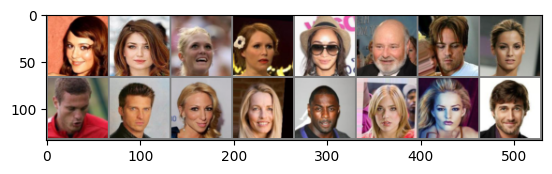

In [6]:
img_grid = torchvision.utils.make_grid(
    tensor=batch,
    nrow=8,
    padding=2,
    normalize=False,
)

plt.imshow(
    torchvision.transforms.ToPILImage()(
        img_grid * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    )
)

### 1. Variational autoencoder

Отличный блогпост со всей математикой: https://lilianweng.github.io/posts/2018-08-12-vae/

Обычный автоэнкодер:

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png" style="background:white" width="600"/>

Вариационный автоэнкодер:

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" style="background:white" width="600"/>

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/reparameterization-trick.png" style="background:white" width="600"/>

#### 1.1. Описание обучения и семплинга

Мы хотим максимизировать evidence lower bound (ELBO):


$\begin{aligned}
\mathcal{L}(\theta, \phi; x)
&= \log p_\theta(\mathbf{x}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) )\\
&= \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\
\theta^{*}, \phi^{*} &= \arg\max_{\theta, \phi} \mathcal{L}(\theta, \phi; x)
\end{aligned}$

Ошибка для обучения VAE:

$L_\text{VAE}(\theta, \phi)  = - \mathcal{L}(\theta, \phi; x) = - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\$



В случае нормального распределения:

$$L_\text{VAE}(\theta, \phi) = \frac{1}{2c} \mathbb{E}[\lVert x - f(z) \rVert^2] + \frac{1}{2}\sum_{i = 1}^d (\sigma_{x, j}^2 + \mu_{x, j}^2 - \log \sigma_{x, j}^2 - 1)$$

Мы будем пользоваться ошибкой для $\beta$-VAE ([Higgins et al., 2017](https://openreview.net/forum?id=Sy2fzU9gl)):

$L_\text{BETA}(\phi, \beta) = - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + \beta D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x})\|p_\theta(\mathbf{z}))$

In [7]:
from lightning.pytorch.utilities.types import OptimizerLRScheduler

class Encoder(nn.Module):
    latent_size: int

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        ...

class Decoder(nn.Module):
    latent_size: int

    def forward(self, z: Tensor) -> Tensor:
        ...


class VAE(L.LightningModule):
    def __init__(self, encoder: Encoder, decoder: Decoder, beta: float = 0.0005):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def training_step(self, batch: Tensor, batch_idx: int) -> None:
        # encode + decode
        mu, logvar = self.encoder(batch)
        eps = torch.randn_like(mu)
        z = mu + eps * torch.exp(0.5 * logvar)
        x_hat = self.decoder(z)

        # calculate loss
        reconstruction_loss = F.mse_loss(batch, x_hat)
        kl = (torch.exp(logvar) + mu**2 - logvar - 1).sum(dim=1).mean()
        loss = reconstruction_loss + self.beta * kl
        self.log("reconstruction_loss", reconstruction_loss, prog_bar=True)
        self.log("kl", kl, prog_bar=True)
        return loss

    def sample(self, n: int) -> Tensor:
        device = next(self.decoder.parameters()).device
        z = torch.randn(n, self.decoder.latent_size, 1, 1, device=device)
        return self.decoder(z)

    def configure_optimizers(self) -> OptimizerLRScheduler:
        return torch.optim.Adam(
            self.parameters(), lr=0.0001, betas=(0.5, 0.999)
        )

#### 1.2. Энкодер и декодер

Тоже для сравнимости возьмём что-то с прошлой недели.

Наш энкодер похож на дискриминатор для GAN, но возвращает параметры для нормального распределения: матожидание и логарифм дисперсии

А декодер - архитектурно один в один с генератором для GAN

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_size: int) -> None:
        super().__init__()
        self.latent_size = latent_size

        self.conv1 = nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.conv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 2)
        self.conv4 = nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, z: Tensor) -> Tensor:
        x = z.view(-1, self.latent_size, 1, 1)  # B x C x H x W
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))


class Encoder(nn.Module):
    def __init__(self, latent_size: int) -> None:
        super().__init__()
        self.latent_size = latent_size
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 8)
        self.conv5 = nn.Conv2d(64 * 8, 2 * latent_size, 4, 1, 0, bias=False)


    def forward(self, x) -> tuple[Tensor, Tensor]:
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        x = self.conv5(x).flatten(1)
        mu = x[:, :self.latent_size]
        logvar = x[:, self.latent_size:]
        return mu, logvar

In [9]:
latent_size = 128
decoder = Decoder(latent_size)
encoder = Encoder(latent_size)

Проверим, что всё работает:

In [10]:
mu, sigma = encoder.forward(batch)
epsilon = torch.randn_like(mu, requires_grad=True)
z = mu + epsilon * sigma
print(mu.shape)
g = decoder.forward(z)
print(g.shape)

torch.Size([16, 128])
torch.Size([16, 3, 64, 64])


#### 1.3. Запуск обучения

Нам понадобится callback, который будет выбирать несколько изображений из датасета, реконструировать их, и генерировать несколько новых из шума. Это позволит нам визуально отслеживать степень регуляризации

In [11]:
class Generate(L.Callback):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.n = n

    def on_train_epoch_end(self, trainer: L.Trainer, pl_module: L.LightningModule) -> None:
        # original
        loader = DataLoader(trainer.train_dataloader.dataset, batch_size=self.n, shuffle=True)
        x = next(iter(loader)).to(device=pl_module.device)

        # reconstructed
        mu, logvar = pl_module.encoder(x)
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(mu)
        z = eps * std + mu
        x_hat = pl_module.decoder(z)

        # new
        z = torch.randn_like(mu)
        x_new = pl_module.decoder(z)


        images = torch.cat([x, x_hat, x_new])
        grid = torchvision.utils.make_grid(
            tensor=images,
            nrow=min(self.n, 8),
            padding=2,
            normalize=True,
        )
        str_title = f"{pl_module.__class__.__name__}_images"
        logger = cast(TensorBoardLogger, pl_module.logger)
        logger.experiment.add_image(str_title, grid, global_step=pl_module.global_step)

In [12]:
trainer = L.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir="logs", name="vae"),
    limit_train_batches=25,
    callbacks=[Generate(n=8)],
)

latent_size = 128
lit = VAE(encoder=Encoder(latent_size), decoder=Decoder(latent_size), beta=0.0005)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model=lit, train_dataloaders=loader)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 4.9 M 
1 | decoder | Decoder | 3.8 M 
------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.642    Total estimated model params size (MB)
/Users/sarapulov/miniconda3/envs/dl-course/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sarapulov/miniconda3/envs/dl-course/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if 

Training: 0it [00:00, ?it/s]

/Users/sarapulov/miniconda3/envs/dl-course/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


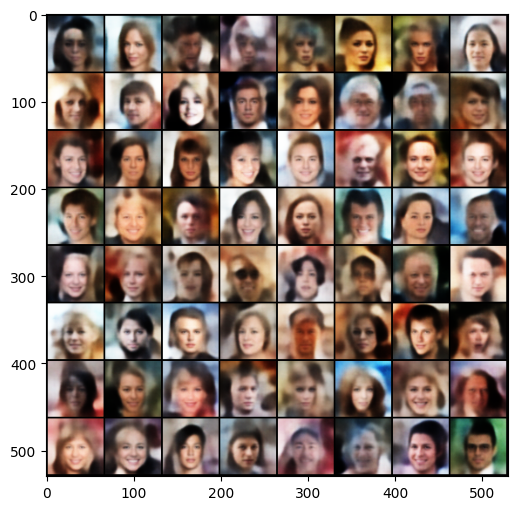

In [14]:
model_version = "version_0"
checkpoint_path = next(Path(f"logs/vae/{model_version}/checkpoints/").glob("*.ckpt"))
lit.load_state_dict(torch.load(checkpoint_path)["state_dict"])
images = lit.sample(n=64)
grid = torchvision.utils.make_grid(
    tensor=images,
    nrow=8,
    padding=2,
    normalize=True,
    # range=(-1, 1),
)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.transforms.ToPILImage()(grid))

#### 1.4. Упражнения

1. Сделайте интерполяцию между двумя латентными векторами и сгенерируйте изображения лиц для полученной последовательности. Вам пригодится функция `torch.lerp`. Почитайте про сферическую линейную интерполяцию (SLERP), сравните результаты с простой линейной.
2. Реализуйте VQ-VAE (https://paperswithcode.com/method/vq-vae)

### 2. Denoising diffusion probabilistic model (DDPM)

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png" style="background:white" width="600"/>

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" style="background:white" width="600"/>

**Прямая диффузия** с расписанием $\{ \beta_t \in (0, 1) \}_{t = 1}^T$:

$q(x_t | x_{t-1}) = \mathcal{N}(x_t ; \sqrt{1 - \beta_t}x_{t-1}, \beta_t \mathbf{I})$

$q(x_{1:T} | x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})$

Трюк с репараметризацией позволяет получить в явном виде выражение для $x_t$ от $x_0$:

$\begin{aligned}
\alpha_t
&= 1 - \beta_t \\
\bar{\alpha}_t &= \prod_{i=1}^t \alpha_i
\end{aligned}$

$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$

<!-- \mathcal{L}(\theta, \phi; x)
&= \log p_\theta(\mathbf{x}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) )\\
&= \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\
\theta^{*}, \phi^{*} &= \arg\max_{\theta, \phi} \mathcal{L}(\theta, \phi; x) -->


**Обратная диффузия**

$p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))$ - похоже на VAE?

$\mu_{\theta}(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(x_t, t) \right)$

В качестве $\sigma_t^2$ берётся $\beta_t$ или $\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$, но можно пытаться выучивать и её

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png" style="background:white" width="800"/>

#### 2.1. Описание обучения и семплинга

Перенесём уравнения из Algorithm 1 в `training_step`, из Algorithm 2 - в `sample`:

In [15]:
class Denoiser(nn.Module):
    # описание интерфейса модели
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        # x - батч с зашумлённым изображениями (B x 3 x 64 x 64)
        # t - номер шага (B x 1)
        ...


class DDPM(L.LightningModule):
    alpha: Tensor
    alpha_bar: Tensor
    beta: Tensor
    sigma: Tensor
    T: int

    def __init__(self, model: Denoiser, beta_0: float, beta_T: float, T: int):
        super().__init__()
        self.model = model
        self.T = T

        # Compute diffusion hyperparameters
        beta = torch.linspace(beta_0, beta_T, T)
        alpha = 1. - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        sigma = torch.sqrt(beta)
        sigma[1:] *= torch.sqrt((1-alpha_bar[:-1]) / (1-alpha_bar[1:]))

        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)
        self.register_buffer("beta", beta)
        self.register_buffer("sigma", sigma)

    def training_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        x_0 = batch
        t = torch.randint(0, self.T, size=(batch.shape[0], 1, 1, 1), device=batch.device)
        eps = torch.randn_like(x_0)

        # forward diffusion
        x_t = torch.sqrt(self.alpha_bar[t]) * x_0 + torch.sqrt(1 - self.alpha_bar[t]) * eps

        # predict added noise and get MSE error
        eps_theta = self.model.forward(x_t, t.view(-1, 1))
        loss = F.mse_loss(eps_theta, eps)
        self.log("reconstr_loss", loss, prog_bar=True)
        return loss
    
    def sample(self, n: int) -> Tensor:
        device = next(self.parameters()).device
        x_t = torch.randn(n, 3, 64, 64, device=device)

        with torch.no_grad():
            for t in range(self.T - 1, -1, -1):
                z = torch.randn_like(x_t) if t > 0 else 0.
                ts = torch.full((n, 1), fill_value=t, device=device)
                # predict epsilon and calculate expectation
                eps_theta = self.model.forward(x_t, ts)
                mu_theta = 1 / torch.sqrt(self.alpha[t]) * (x_t - (1 - self.alpha[t]) / (torch.sqrt(1 - self.alpha_bar[t])) * eps_theta)
                
                # get new x_t
                x_t = mu_theta + self.sigma[t] * z

        return x_t

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optim = torch.optim.AdamW(
            self.parameters(), lr=0.0002,
        )
        return {
            "optimizer": optim,
        }

#### 2.2. Архитектура модели: time-conditioned U-Net

Для примера возьмём U-Net из практики по сегментации, но его придётся модифицировать: теперь на вход модели приходит не только изображение, но и номер шага

Кодировать номер шага можно, напрмер, используя синусоидальные эмбеддинги, как в оригинальном трансформере

d - желаемый размер вектора, кодирующего позицию
for 
$
i \in [1, d] \\
\begin{aligned}
PE(t, 2i) = \sin \left( \frac{t}{10000^{2i / d}} \right) \\
PE(t, 2i + 1) = \cos \left( \frac{t}{10000^{2i / d}} \right)
\end{aligned}
$

In [16]:
import math

class PositionalEncoding(nn.Module):
    pe: Tensor

    def __init__(self, encoding_size: int, max_len: int = 1000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, encoding_size, 2) * (-math.log(10000.0) / encoding_size))
        pe = torch.zeros(max_len, encoding_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, t: Tensor) -> Tensor:
        """
        Arguments:
            t: Tensor, shape ``[batch_size]``
        """
        return self.pe[t]

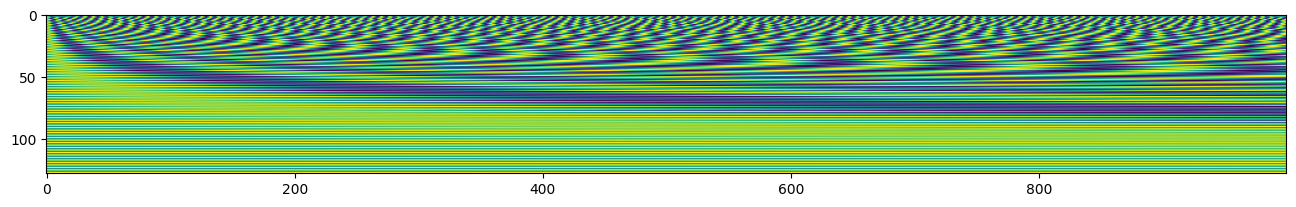

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

plt.imshow(PositionalEncoding(128)(torch.arange(1000)).T)

Внесём правки в модули U-Net, чтобы мы могли передать номер шага в свёрточные слои. Как это сделать?

Подсказка: `PositionalEncoding` можно добавить внутрь U-Net для кодирования номера шага, чтобы внутренние блоки получали уже векторное представление шага и как-то добавляли его к каналам изображения. Можно попробовать
- конкатенацию: C' = C + encoding_size, то есть каналов станет больше
- сложение: линейно преобразуем закодированный номер шага к нужному размеру с помощью линейного слоя (`nn.Linear`: $\mathbb{R}^d \rightarrow \mathbb{R}^C$) и прибавляем вдоль размерности каналов; broadcasting в помощь!

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [19]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
        encoding_size: int = 32,  # размер PositionEncoding
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        xs = []
        x = self.in_conv(x)
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        logits = self.head(x)
        return logits

In [20]:
model = UNet(n_channels=3, n_classes=3, channel_sizes=[64, 128, 256, 512], bilinear=True)
sum([p.numel() for p in model.parameters()])

4326723

In [21]:
x_0 = torch.randn(16, 3, 64, 64)
t = torch.randint(0, 1000, size=(16, 1))
eps = model.forward(x_0, t)
print(eps.shape)

torch.Size([16, 3, 64, 64])


#### 2.3. Запуск обучения

Сделаем похожий callback для отрисовки примеров изображений:

In [22]:
class Generate(L.Callback):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.n = n

    def on_train_epoch_end(self, trainer: L.Trainer, pl_module: L.LightningModule) -> None:
        images = pl_module.sample(self.n)
        grid = torchvision.utils.make_grid(
            tensor=images,
            nrow=8,
            padding=2,
            normalize=True,
        )
        str_title = f"{pl_module.__class__.__name__}_images"
        logger = cast(TensorBoardLogger, pl_module.logger)
        logger.experiment.add_image(str_title, grid, global_step=pl_module.global_step)

In [23]:
trainer = L.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir="logs", name="ddpm"),
    limit_train_batches=100,
    callbacks=[Generate(n=16)],
)
model = UNet(n_channels=3, n_classes=3, channel_sizes=[64, 128, 256, 512], bilinear=True, encoding_size=32)
lit = DDPM(model=model, beta_0=0.0001, beta_T=0.02, T=300)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model=lit, train_dataloaders=loader)


  | Name  | Type | Params
-------------------------------
0 | model | UNet | 4.3 M 
-------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.307    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
model_version = "version_0"
checkpoint_path = next(Path(f"logs/ddpm/{model_version}/checkpoints/").glob("*.ckpt"))
lit.load_state_dict(torch.load(checkpoint_path)["state_dict"])
lit.to(device="mps")
images = lit.sample(n=64)
grid = torchvision.utils.make_grid(
    tensor=images,
    nrow=8,
    padding=2,
    normalize=True,
)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.transforms.ToPILImage()(grid))

#### 2.3. Упражнения

Попробуйте добиться хорошего качества генерации лиц.
1. Модифицируйте архитектуру. Попробуйте как-то иначе включать в UNet данные о номере шага
2. Посмотрите на зависимость качества модели от числа шагов диффузии и от [параметризации расписания](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#parameterization-of-beta_t)
3. Добавьте в `configure_optimizers()` управление шагом оптимизатора через `torch.optim.lr_scheduler.CosineAnnealingLR`
4. Попробуйте сделать генерацию в несколько шагов: пусть модель сначала генерирует лицо в меньшем разрешении (скажем, 32x32), а затем использует результат в качестве условия для генерации лица в более высоком разрешении.